In [ ]:
# Image Classification Using CNNs and CUDA
#----------------------#
# Reema Aldanish

**In this project, the FashionMNIST dataset was used, consisting of grayscale images of various types of clothing, such as shirts and shoes. The goal is to train a deep learning model, Vision Transformer, to classify the images into 10 categories.**

## Objectives:
Load and train the model to classify clothing using the Vision Transformer.
Analyze performance using a Confusion Matrix to identify correct and incorrect classifications.
Evaluate the model's accuracy by analyzing its performance on the validation set.

# Import Libraries:

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.optim import AdamW
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the dataset using torchvision.datasets.

FashionMNIST data will be used.

In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
val_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
print("Dataset loaded successfully.")

100%|██████████| 26421880/26421880 [00:01<00:00, 16902320.09it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 275495.84it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5121634.30it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7466209.20it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Dataset loaded successfully.


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
val_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")

Number of training images: 60000
Number of validation images: 10000


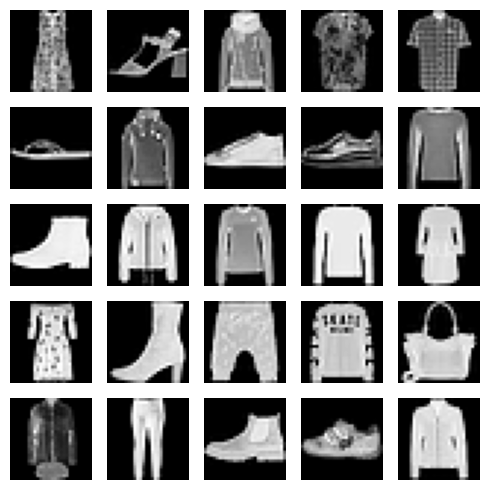

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=25, shuffle=True)
data_iter = iter(train_loader)
images, labels = next(data_iter)
fig, axes = plt.subplots(5, 5, figsize=(5, 5))
axes = axes.flatten()
for img, ax in zip(images, axes):
    img = img.numpy().squeeze()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print("DataLoader created successfully.")

DataLoader created successfully.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
weights = ViT_B_16_Weights.DEFAULT
model = vit_b_16(weights=weights)
model.heads.head = nn.Linear(model.heads.head.in_features, 10)
model = model.to(device)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
val_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=3e-4)
num_epochs = 7
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')

Using device: cuda


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 220MB/s]


Epoch [1/7], Loss: 0.4070
Epoch [2/7], Loss: 0.2710
Epoch [3/7], Loss: 0.2429
Epoch [4/7], Loss: 0.2195
Epoch [5/7], Loss: 0.2040
Epoch [6/7], Loss: 0.1895
Epoch [7/7], Loss: 0.1732
Validation Accuracy: 90.83%


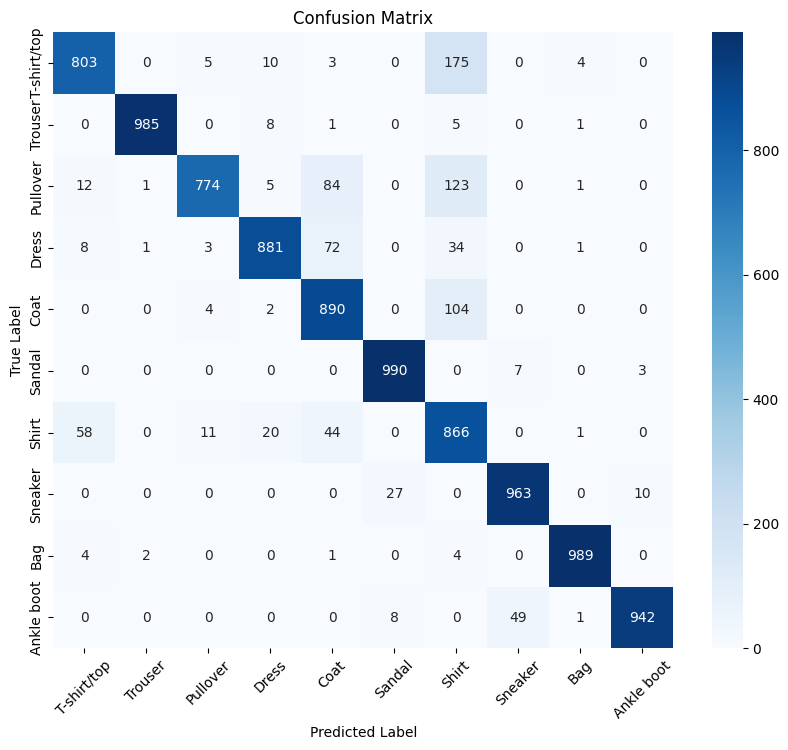

In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])
val_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
class_names = val_dataset.classes
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.show()

The model performs well in categories like Trouser and Sandal, with nearly perfect predictions. However, it struggles to distinguish between similar categories like T-shirt/top and Shirt, where some errors are observed. Overall, the model demonstrates good accuracy in classifying most categories.



---

